# The relationship between pupil size and activity in visual cortex

## Imports and constants

In [1]:
from datamatrix import io, plot
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datamatrix import operations as ops, DataMatrix, FloatColumn

In [2]:
MAX_ERR = np.inf
MIN_X = 2
MAX_X = 158
MIN_Y = 2
MAX_Y = 126
MIN_SD = 1
MAX_SD = 62
XC = 80
YC = 64
OUTLIERS = {5}
SRC_NIFTI = '../outputs/correlation-matrix.pkl'
SRC_LONGISH = '../outputs/longish-correlation-matrix.csv'
VISUAL_CORTEX = {'V1', 'V2', 'V3', 'V4'}
LGN = 'LGN'
COLORS = {
    'V1': '#4DB6AC',
    'V2': '#009688',
    'V3': '#00796B',
    'V4': '#004D40',
}

## Read data

The data is read in two formats:

- A DataMatrix `dm` with one row for each roi/ subject, and the imaging data as NiftiColumns
- A "longish" DataMatrix `ldm` with one row for each voxel

The data is filtered based on the PRF properties to avoid poorly fitted PRFs from being included in the analysis.

In [3]:
def mask(nft, mask):
    
    """Set voxels that match the mask to nan"""
    
    nft.get_data()[mask] = np.nan


dm = io.readpickle(SRC_NIFTI)
dm = dm.roi == VISUAL_CORTEX
dm = dm.sub != OUTLIERS
for row in dm:
    if row.roi == 'LGN':
        continue
    a = row.prf_err.get_data()
    x = row.prf_x.get_data()
    y = row.prf_y.get_data()
    sd = row.prf_sd.get_data()
    err = np.where(
        (a > MAX_ERR) |
        (x < MIN_X) | (x >= MAX_X) |
        (y < MIN_Y) | (y >= MAX_Y) |
        (sd < MIN_SD) | (sd >= MAX_SD)
    )
    n_poor = len(err[0])
    n_total = np.sum(~np.isnan(a))
    mask(row.prf_x, err)
    mask(row.prf_y, err)
    mask(row.prf_sd, err)
    mask(row.prf_err, err)
    mask(row.r_vc_pupil, err)
    mask(row.r_vc_lum, err)
dm.r_pupil = [np.nanmedian(row.r_vc_pupil.get_data()) for row in dm]
dm.r_lum = [np.nanmedian(row.r_vc_lum.get_data()) for row in dm]
dm.m_prf_err = [np.nanmedian(row.prf_err.get_data()) for row in dm]
dm.m_prf_sd = [np.nanmedian(row.prf_sd.get_data()) for row in dm]
dm.m_prf_absx = [np.nanmedian(np.abs(row.prf_x.get_data() - XC)) for row in dm]
dm.m_prf_absy = [np.nanmedian(np.abs(row.prf_y.get_data() - YC)) for row in dm]
dm.m_prf_ecc = [
    np.nanmedian(
        (
            (row.prf_y.get_data() - XC) ** 2 +
            (row.prf_y.get_data() - YC) ** 2
        ) ** .5
    )
    for row in dm
]
# And now the longish matrix
ldm = io.readtxt(SRC_LONGISH)
ldm_lgn = ldm.roi == LGN
print('Number of LGN voxels included in analysis: {}'.format(len(ldm_lgn)))
print('Total number VC of voxels: {}'.format(len(ldm)))
ldm = ldm.roi == VISUAL_CORTEX
ldm = ldm.prf_err <= MAX_ERR
ldm = ldm.prf_x > MIN_X
ldm = ldm.prf_x <= MAX_X
ldm = ldm.prf_y > MIN_Y
ldm = ldm.prf_y <= MAX_Y
ldm = ldm.prf_sd > MIN_SD
ldm = ldm.prf_sd <= MAX_SD
ldm = ldm.sub != OUTLIERS
print('Number of VC voxels included in analysis: {}'.format(len(ldm)))

/home/sebastiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/home/sebastiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/home/sebastiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater_equal


Number of LGN voxels included in analysis: 360
Total number VC of voxels: 55080
Number of VC voxels included in analysis: 28079


# Plot: Correlations between pupil size, luminance, and visual-cortex activity

In [4]:
def roi_hist(ldm, col):
    
    plt.xlim(-.25, .25)
    plt.axvline(0, color='black', linestyle='-')
    for roi, rdm in ops.split(ldm.roi):
        sns.distplot(
            rdm[col],
            label='{} (N={})'.format(roi, len(rdm[col])),
            hist=True,
            kde=False,
            bins=20,
            hist_kws={
                "alpha": .8,
                "color": COLORS[roi]
            }
        )
        plt.axvline(rdm[col].mean, color=COLORS[roi], linestyle=':')
    plt.ylabel('Voxel count')
    plt.xlabel('Correlation (r)')
    plt.legend()    

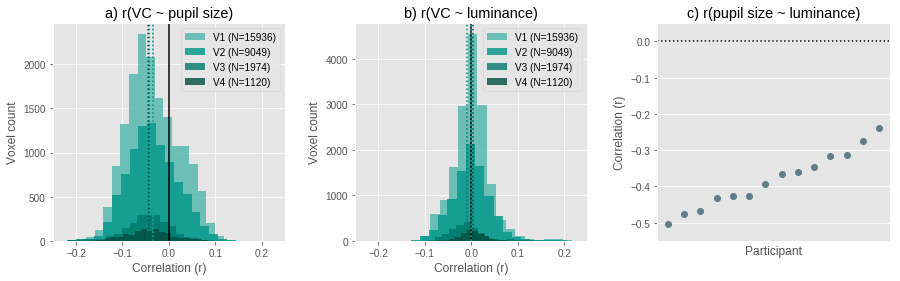

In [5]:
plt.figure(figsize=(15, 4))
plt.subplots_adjust(wspace=.3)
# Correlated pupil size and visual cortex
plt.subplot(1,3,1)
plt.title('a) r(VC ~ pupil size)')
roi_hist(ldm, 'r_vc_pupil')
# Correlated luminance and visual cortex
plt.subplot(1,3,2)
plt.title('b) r(VC ~ luminance)')
roi_hist(ldm, 'r_vc_lum')
plt.subplot(1,3,3)
# Correlated pupil size and luminance
plt.ylabel('Correlation (r)')
plt.title('c) r(pupil size ~ luminance)')
plt.axhline(0, color='black', linestyle=':')
r = sorted([sdm.r_lum_pupil.mean for sub, sdm in ops.split(dm.sub)])
plt.plot(r ,'o', color='#607D8B')
plt.xlabel('Participant')
plt.xticks([])
plt.ylim(-.55, .05)
plot.save('correlation-plot-dist', show=True)

# Plot: PRF properties

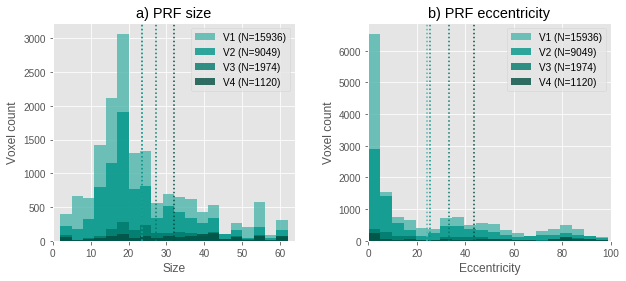

In [6]:
plt.figure(figsize=(10, 4))
plt.subplots_adjust(wspace=.3)
plt.subplot(1, 2, 1)
plt.title('a) PRF size')
roi_hist(ldm, 'prf_sd')
plt.xlabel('Size')
plt.xlim(0, 64)
plt.subplot(1, 2, 2)
plt.title('b) PRF eccentricity')
roi_hist(ldm, 'ecc')
plt.xlabel('Eccentricity')
plt.xlim(0, 100)
plot.save('prf-properties', show=True)

# Heatmaps

Various heatmaps to inspect how properties are distributed across the visual field, across all ROIs and for each ROI separately.

First some helper functions.

In [7]:
def density_map(ldm, downsample=8):

    a = np.zeros((2 * YC // downsample, 2 * XC // downsample))
    for i, row in enumerate(ldm):
        x = row.prf_x // downsample
        y = row.prf_y // downsample
        r = row.r_vc_pupil
        a[y, x] += 1
    plt.axis('off')
    sns.heatmap(a, cbar=False)
    
    
def size_map(ldm, downsample=16):

    a = np.empty((len(ldm), 2 * YC // downsample, 2 * XC // downsample))
    a[:] = np.nan
    for i, row in enumerate(ldm):
        x = row.prf_x // downsample
        y = row.prf_y // downsample
        r = row.prf_sd
        a[i, y, x] = r
    heatmap = np.nanmean(a, axis=0)
    plt.axis('off')
    sns.heatmap(heatmap, cbar=False)
        
    
def correlation_map(ldm, downsample=16):

    a = np.empty((len(ldm), 2 * YC // downsample, 2 * XC // downsample))
    a[:] = np.nan
    for i, row in enumerate(ldm):
        x = row.prf_x // downsample
        y = row.prf_y // downsample
        r = row.r_vc_pupil
        a[i, y, x] = r
    heatmap = np.nanmean(a, axis=0)
    plt.axis('off')
    sns.heatmap(heatmap, cbar=False, center=0)
    
    
def roi_plot(ldm, fnc):
        
    plt.figure(figsize=(15, 3))
    plt.subplots_adjust(wspace=.1, hspace=.1)
    plt.subplot(1, 5, 1)
    plt.title('All (V1 - V4)')
    fnc(ldm)
    plt.subplot(1, 5, 2)
    plt.title('V1')
    fnc(ldm.roi == 'V1')
    plt.subplot(1, 5, 3)    
    plt.title('V2')
    fnc(ldm.roi == 'V2')
    plt.subplot(1, 5, 4)    
    plt.title('V3')
    fnc(ldm.roi == 'V3')
    plt.subplot(1, 5, 5)
    plt.title('V4')
    fnc(ldm.roi == 'V4')


The density of PRFs.

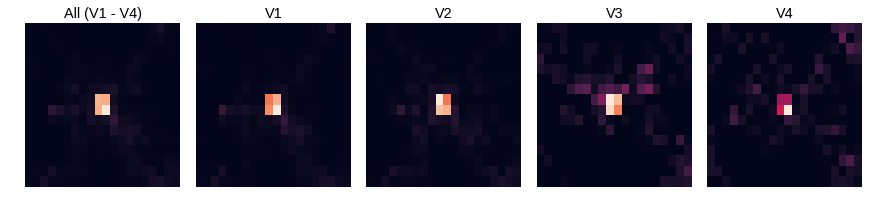

In [8]:
roi_plot(ldm, density_map)
plot.save('map-density', show=True)

/home/sebastiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice


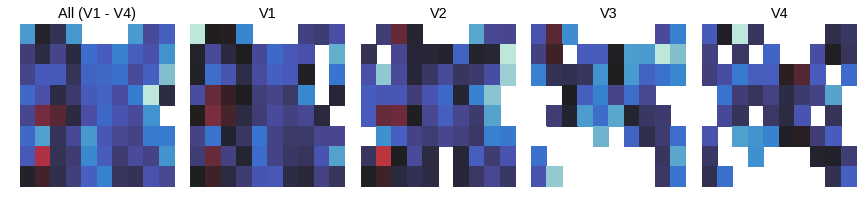

In [9]:
roi_plot(ldm, correlation_map)
plot.save('map-correlation', show=True)

/home/sebastiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


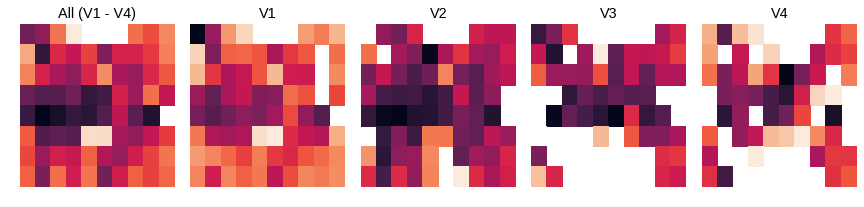

In [10]:
roi_plot(ldm, size_map)
plot.save('map-prf-size', show=True)

# Statistics

In [11]:
from datamatrix.rbridge import lme4
lme4.verbose = True

## Relationship between PRF properties and the VC-pupil correlation.

In [12]:
lme4.lmer(ldm, 'r_vc_pupil ~ (1|sub)')

df,effect,est,p,se,t
13.0010038214515,(Intercept),-0.0354230713692835,0.00219379226206244,0.00931408755297139,-3.80317139685709


In [13]:
lme4.lmer(ldm, 'r_vc_pupil ~ r_vc_lum + (1+r_vc_lum|sub)')

df,effect,est,p,se,t
12.9974068448793,(Intercept),-0.0357388146405776,0.000721462330431941,0.00812729165522449,-4.39738305904201
12.9642427495275,r_vc_lum,-0.383269602161739,0.00279482962793781,0.104197194212611,-3.6783101988302


In [14]:
ldm.c_roi = ldm.roi @ (lambda roi: 0 if roi == 'V1' else 1 if roi == 'V2' else 2 if roi == 'V3' else 3)
lme4.lmer(ldm, 'r_vc_pupil ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
13.0033591011902,(Intercept),-0.0339951026214396,0.00597042441245092,0.0103640978675754,-3.28008313466385
13.0513288148687,c_roi,-0.00222282916309324,0.412153314903289,0.00262375377753439,-0.847194268809054


In [15]:
lme4.lmer(ldm, 'r_vc_pupil ~ prf_y + (1+prf_y|sub)')

df,effect,est,p,se,t
44.0491519171931,(Intercept),-0.0472859706287033,4.6299362950046e-08,0.00718096944298195,-6.58490068843232
16.9952641154411,prf_y,0.000174225699045561,0.00413827424962577,5.2631323296009e-05,3.31030436125806


In [16]:
lme4.lmer(ldm, 'r_vc_pupil ~ prf_x + (1+prf_x|sub)')

df,effect,est,p,se,t
58.2125134536062,(Intercept),-0.0289045131205545,2.5848494127679e-05,0.00632422195304519,-4.57044571413826
21.0163192913464,prf_x,-8.92651757231932e-05,0.0146337295099273,3.35541518842098e-05,-2.66033175361528


In [17]:
lme4.lmer(ldm, 'r_vc_pupil ~ ecc + (1+ecc|sub)')

df,effect,est,p,se,t
42.3954968660233,(Intercept),-0.0358436756553087,1.08961497859524e-06,0.00630348906590593,-5.68632312685027
13.7424472080773,ecc,3.51073806388178e-05,0.606709816818503,6.66385888556898e-05,0.526832594172201


In [18]:
lme4.lmer(ldm, 'r_vc_pupil ~ prf_sd + (1+prf_sd|sub)')

df,effect,est,p,se,t
29.2747026324472,(Intercept),-0.0331744347754354,0.000874076915094837,0.00895163661269119,-3.7059630781261
19.0024123217112,prf_sd,-0.000118015314109236,0.487708797524834,0.000166753984263405,-0.707721105618797


## Basic PRF properties as a function of ROI

In [19]:
lme4.lmer(ldm, 'ecc ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
13.0261923685879,(Intercept),23.4166717452972,3.03618404042377e-07,2.45378080486183,9.54309842953385
12.9743842366679,c_roi,4.92952380667142,0.00274320509308439,1.33683756473457,3.68745159225848


In [20]:
lme4.lmer(ldm, 'prf_sd ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
13.0043522134383,(Intercept),23.0998957368709,2.15949315308842e-08,1.93084091849142,11.9636452261013
13.0109838579344,c_roi,2.29181194631132,0.00056867516523969,0.506398286647552,4.52571030894185


In [21]:
lme4.lmer(ldm, 'prf_sd ~ ecc + (1+ecc|sub)')

df,effect,est,p,se,t
27.0896299187019,(Intercept),18.5773707764144,1.7762154235254e-12,1.5288302359266,12.1513627477121
15.6951751455145,ecc,0.229894332017922,3.90260324985103e-12,0.0123188519358011,18.6619932779452


## Relationship between luminance and VC activity

In [22]:
lme4.lmer(ldm, 'r_vc_lum ~ (1|sub)')

df,effect,est,p,se,t
13.0000262303343,(Intercept),0.000310506877300559,0.949228106617269,0.0047831713741367,0.0649165277622112


In [23]:
lme4.lmer(ldm, 'r_vc_lum ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
12.9988311381316,(Intercept),0.00164092576500197,0.772547833435739,0.00555981195981826,0.295140514978066
13.0811528913048,c_roi,-0.00218048686917322,0.249332058572144,0.00180865155988027,-1.20558703375545


In [24]:
lme4.lmer(ldm, 'r_vc_lum ~ prf_y + (1+prf_y|sub)')

df,effect,est,p,se,t
20.7965918243339,(Intercept),-0.0368421812054358,9.53555922878594e-05,0.007652511684315,-4.81439071578937
18.4275478229666,prf_y,0.000537049428687889,5.40389986521062e-06,8.51267872370447e-05,6.30881824768527


In [25]:
lme4.lmer(ldm, 'r_vc_lum ~ prf_x + (1+prf_x|sub)')

df,effect,est,p,se,t
23.6352529175472,(Intercept),-0.0096476639099591,0.119904245055548,0.00597925160445071,-1.61352365616757
18.7328162360016,prf_x,0.000128508734617385,0.019376886757457,5.0242700271342e-05,2.55775931475333


In [26]:
lme4.lmer(ldm, 'r_vc_lum ~ ecc + (1+ecc|sub)')

df,effect,est,p,se,t
4.86600876137157,(Intercept),-0.00235923241872475,0.748406912221802,0.00694951786614808,-0.339481452406483
8.06560701318409,ecc,0.000125641909248491,0.0819526939552743,6.32546264443439e-05,1.98628806003684


In [27]:
lme4.lmer(ldm, 'r_vc_lum ~ prf_sd + (1+prf_sd|sub)')

df,effect,est,p,se,t
12.9554858616613,(Intercept),-0.00941225218198835,0.131835327427693,0.00585196057159116,-1.60839295939226
12.9809580839273,prf_sd,0.000396942252943553,0.0480131833862555,0.0001818460418658,2.18284791283217


## LGN properties

In [28]:
lme4.lmer(ldm_lgn, 'r_vc_lum ~ (1|sub)')

df,effect,est,p,se,t
13.9999864553514,(Intercept),-0.00230426825975755,0.604600246740953,0.00434990927432099,-0.529727889581616


In [29]:
lme4.lmer(ldm_lgn, 'r_vc_pupil ~ (1|sub)')

df,effect,est,p,se,t
13.9999990171305,(Intercept),0.00125929312288889,0.85039810883355,0.00655432648223897,0.192131583054543
